In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit.visualization import plot_histogram
from ai_quantum.quantum.qaoa import QAOA
from return_cov import f_return_cov

from ai_quantum.ai_models.rnn import RNN_QAOA
import torch
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline
pd.options.mode.chained_assignment = None

In [ ]:
expected_value, cov_matrix = f_return_cov()

## Neural Networking model

In [ ]:
def f_loss(energies, sum_w):
    response = torch.mean((torch.exp(-sum_w)-torch.exp(-energies)).pow(2))
    return response

In [ ]:
def epoch_train(model, optimizer, batch_size, beta_temp, depth):
    sum_w, energies, count, gamma, beta = model.forward_qc(beta_temp, depth)
    for _ in range(batch_size):
        sum_w_, energy_, count, gamma, beta = model.forward_qc(beta_temp, depth)
        sum_w = torch.cat((sum_w, sum_w_), dim=0)
        energies = torch.cat((energies, energy_), dim=0)
    
    optimizer.zero_grad()
    loss = f_loss(energies, sum_w)
    loss.backward()
    optimizer.step()
        
    return loss.item()

In [ ]:
q = 0.5 
B  = 2 
lamb= 1

vocab_size = 5
embedding_dim = 100
hidden_size = 20

In [6]:
nn_qaoa = RNN_QAOA(vocab_size, embedding_dim, hidden_size, expected_value, cov_matrix, q, B, lamb)
optimizer = optim.Adam(nn_qaoa.parameters(), lr=1e-2)

## Model Training

In [ ]:
depth = 1
beta_temp = 1

batch_size = 15
epochs = 30

In [8]:
for i in range(epochs):
    loss_i = epoch_train(nn_qaoa, optimizer, batch_size, beta_temp, depth)
    print(f"Epoch {i}, Loss: {loss_i:.2f}")

Epoch 0, Loss: 26.37
Epoch 1, Loss: 88.91
Epoch 2, Loss: 40.25
Epoch 3, Loss: 20.82
Epoch 4, Loss: 12.37
Epoch 5, Loss: 9.26
Epoch 6, Loss: 1.07
Epoch 7, Loss: 18.40
Epoch 8, Loss: 20.29
Epoch 9, Loss: 30.13
Epoch 10, Loss: 8.48
Epoch 11, Loss: 7.93
Epoch 12, Loss: 29.72
Epoch 13, Loss: 7.70
Epoch 14, Loss: 11.45
Epoch 15, Loss: 10.93
Epoch 16, Loss: 13.68
Epoch 17, Loss: 12.03
Epoch 18, Loss: 15.04
Epoch 19, Loss: 15.58
Epoch 20, Loss: 4.90
Epoch 21, Loss: 5.09
Epoch 22, Loss: 4.01
Epoch 23, Loss: 12.83
Epoch 24, Loss: 5.37
Epoch 25, Loss: 5.37
Epoch 26, Loss: 3.76
Epoch 27, Loss: 8.44
Epoch 28, Loss: 11.47
Epoch 29, Loss: 8.06


## Inference

In [9]:
nn_qaoa.eval()
with torch.no_grad():
    w, energy, count, gamma, beta = nn_qaoa.forward_qc(100000, depth)
energy

tensor([-3.0149], dtype=torch.float64)

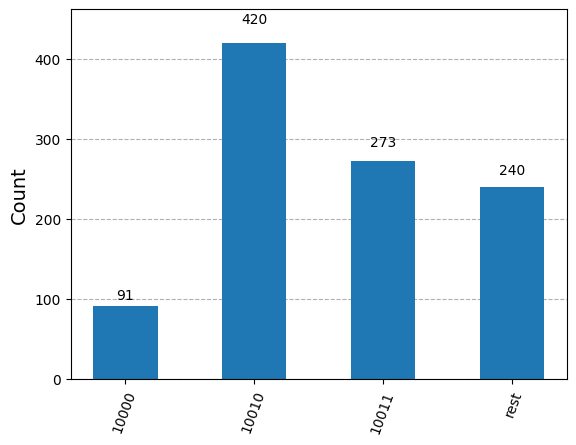

In [10]:
plot_histogram(count, number_to_keep=3)
plt.show()

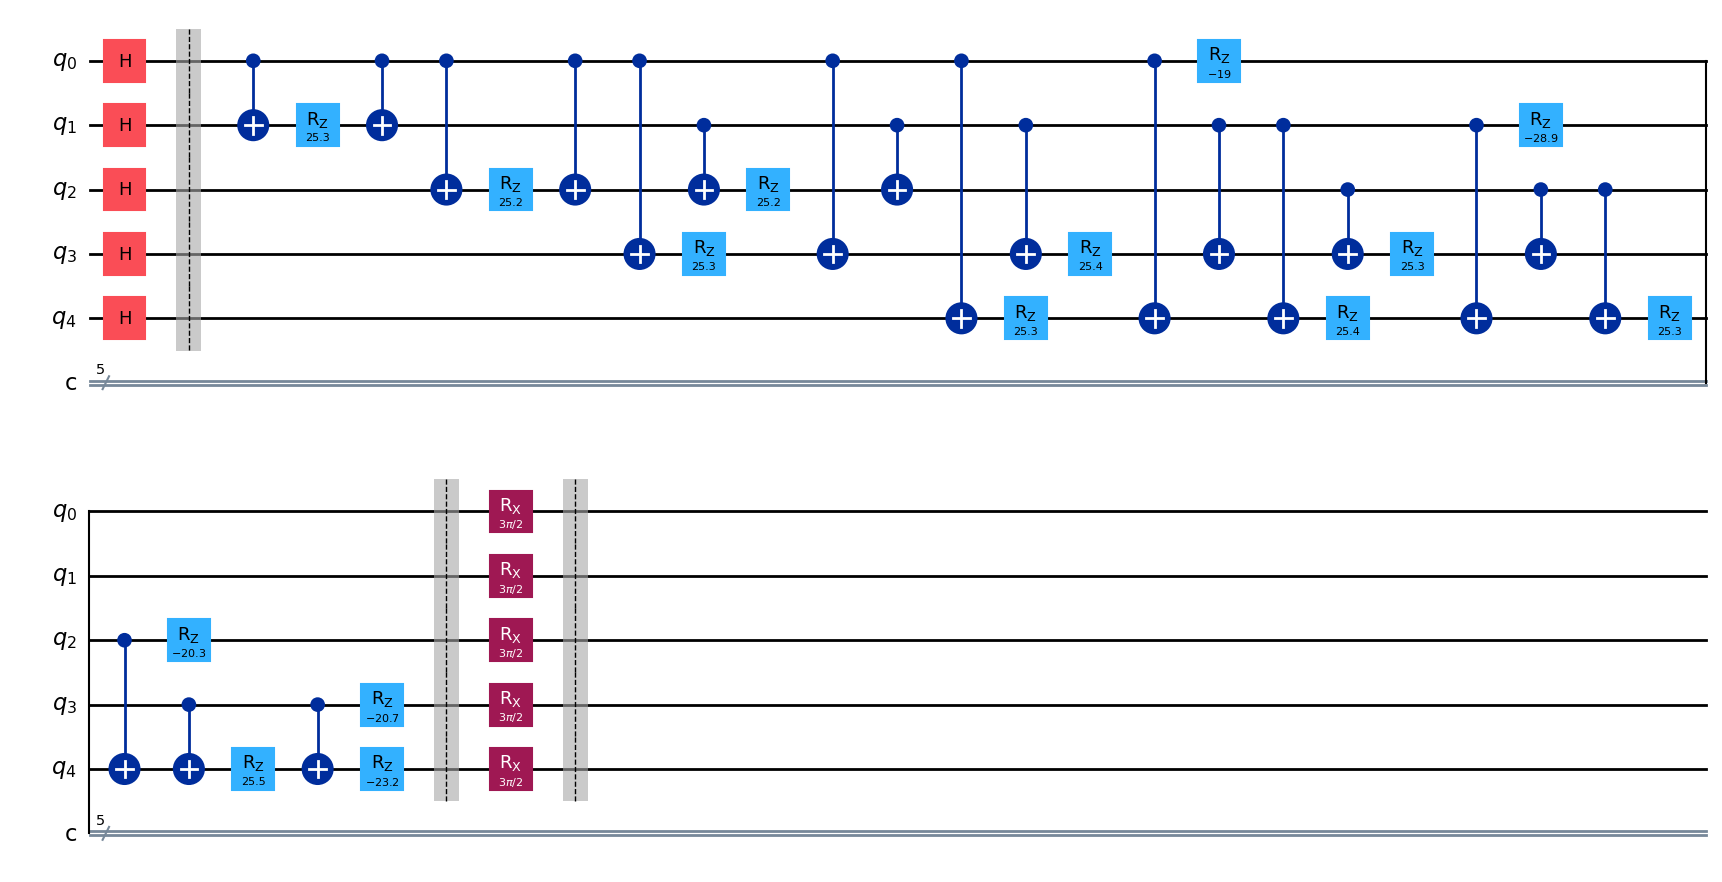

In [11]:
qaoa = QAOA(expected_value, cov_matrix, q, B, lamb)
for i in range(len(gamma)):
    qaoa.add_layer(gamma[i], beta[i])
qaoa.draw()